# Finding the optimal portfolio allocation via Policy Gradient Methods

In [1]:
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from statsmodels.tsa.api import VAR
import random
import math
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.optimize as sci
import seaborn as sns

#### divide data in training and test
#### on traing data: estimate VAR, generate synthetic data and return a data frame

In [2]:
# function estimates VAR and returns model and dataset
def estimate_VAR(data):
    # take difference of timeseries to avoid stationarity
    data_stationary = data.diff().dropna()

    # fit VAR
    var_model = VAR(data_stationary)
    var_model_fitted = var_model.fit()
    return var_model_fitted

In [3]:
# function generates a data set of size num_obs - 1
# forecast horizon is 1 months but can be changed
# num_obs cannot be larger than df.shape[0]
def generate_data(df, df_stationary, model_fitted, numb_obs, forecast_window = 1):

    lag_order = model_fitted.k_ar

    # inputs to generate a random vector
    mean_vector = np.zeros(df_stationary.shape[1])
    covariance_matrix = df_stationary.cov()

    # instantiate dataframes to store the results
    df_results = pd.DataFrame(columns=df.columns, index=range(numb_obs))
    df_forecast = pd.DataFrame(columns=df.columns, index=range(numb_obs))

    # all subsequent data points in forecast
    for i in range(lag_order, numb_obs):
        forecast_input = df_stationary.values[i-lag_order: i] 
        fc = model_fitted.forecast(y=forecast_input, steps=forecast_window)
        df_forecast.iloc[i-lag_order,:] = fc + np.random.multivariate_normal(mean_vector, covariance_matrix)
        df_results.iloc[i,:] = df.iloc[i-lag_order,:] + fc[0] + np.random.multivariate_normal(mean_vector, covariance_matrix)

    return df_results

### Functions to measure the performance

In [4]:
# calculates the max draw down
def max_draw_down(input_list):
    max_draw = np.inf
    for i in range(1, len(input_list)):
        draw_down = input_list[i] - input_list[i-1]
        if draw_down < max_draw:
            max_draw = draw_down
    return max_draw

# calculates the average return
def average_return(input_list, num_of_days):
    change = input_list[-1] - input_list[0]
    return change / (num_of_days/365)

# calcultates the standard deviation
def std_of_return(input_list):
    series = pd.Series(input_list).diff()
    return series.dropna().std()

def performance(input_list, num_of_days):
    print(f'average return: {round(average_return(input_list=input_list, num_of_days=num_of_days)*100,2)} p.a.%')
    print(f'max. draw down : {round(max_draw_down(input_list=input_list)*100,2)}%')
    print(f'Risk-return-ratio: {round(np.mean(pd.Series(input_list).diff())/std_of_return(input_list=input_list),2)}')
    print("")

In [5]:
# function findes in the array vec the entry with the highest value
# and returns a one-hot-encoded array where the 1 is in the position of the highest value

def find_best_dis(vec):
    order = np.argmax(vec)
    if order == 0:
        return [1, 0, 0]
    elif order == 1:
        return [0, 1, 0]
    elif order == 2:
        return [0, 0, 1]

### defines a class of neural nets

In [6]:
# Defines a class of neuronal nets
# first and last layer defined by problem, hidden layers to be choosen
# flag states whether cross-entropy should be used in loss function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class NeuronalNet(nn.Module):
    def __init__(self, batch_size):
        # inherits from nn.Module
        # invoke initiator of parent class
        super().__init__()
        self.batch_size = batch_size
    
    # define model
        l1 = 8 # input depending on number of time series
        l2 = 20#10
        l3 = 60#25
        l4 = 3

        self.model = nn.Sequential(
            nn.Linear(l1,l2),
            nn.ReLU(),
            nn.Dropout(0.2), # randomly deletes 20% of values to avoid overfitting
            nn.Linear(l2,l3),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(l3, l4),
            nn.Softmax(dim=0)
        )
      
        # define loss function
        self.loss_function = nn.MSELoss()
        
        # define optimizer
        self.optimiser = torch.optim.Adam(self.parameters(), lr = 0.0001) 

        # counter and store loss
        self.counter = 0
        self.loss_out  = [np.inf]

    # forward pass
    def forward(self, inputs):
        return self.model(inputs)
    
    # trainings function
    def train(self, inputs, targets):
        # calc loss
        loss = self.loss_function(inputs, targets)
        # count and store loss
        self.counter += 1
        self.loss_out.append(loss.item())
        # learn
        self.optimiser.zero_grad() # resets the optimizer 
        loss.backward() # backpropagation
        self.optimiser.step() # re-adjust weights
        pass
    
    # return current loss
    def get_loss(self):
        return np.average(self.loss_out[- self.batch_size :])

    # plot loss function
    def plot(self):
        plt.figure(figsize=(10,8))
        df = pd.DataFrame(self.loss_out, columns = ['loss'])
        df = df[df['loss'] < 20000]
        plt.plot(df.index, df['loss'], label='loss')
        plt.xlabel('number of iterations', loc='right', fontsize=16)
        plt.ylabel('value of the loss function', loc='top', fontsize=16)
        plt.title('Performance of RL model', fontsize=20)
        plt.legend(fontsize=14)
        plt.show()

#### defines a class for early stopping

In [7]:
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)
        return model

In [8]:
def calc_return(df, i , prob):
    delta = (df.iloc[i+1,:] - df.iloc[i,:])/df.iloc[i,:] # percentage change
    period_return = delta[0:3].to_numpy().astype(float)
    weighted_period_utility = torch.multiply(torch.FloatTensor(period_return), prob )
    return weighted_period_utility

### functions to calculate the portfolio with the highest Sharpe ratio

In [9]:
# function to calculate portfolio return given a vector of weights
def portfolio_return_mu(weights, mu):
    return weights.T @ mu

# function to calculate portfolio risk (std) given a vector of weights
def portfolio_sigma(weights, sigma):
    return np.sqrt(weights.T @ sigma @ weights)

# Return an array of equal weights that sum to one of dimension length
def get_equal_weights(length):
    return np.array([1 / length] * length)

### function to find the efficient frontier

In [10]:
# find the highest Sharpe-ratio

def calc_efficient_frontier(n_assets, mu, sigma,  n_portfolios = 500000):
    # container to store results
    portfolio_returns = []
    portfolio_risks = []
    portfolio_weights = []

    max_sharpe_ratio = -np.inf

    # simulate random portfolios
    for _ in range(n_portfolios):
        # random weights
        weights = np.random.random(n_assets)
        weights /= np.sum(weights)  # normalize to sume to one
        
        # calc expected return of portfolio
        portfolio_return =  portfolio_return_mu(mu = mu, weights = weights) *12 # to get p.a. values
        
        # calc portfolio risk (std)
        portfolio_std_dev =  portfolio_sigma(weights=weights, sigma=sigma) * np.sqrt(12)
        
        # store results
        portfolio_returns.append(portfolio_return)
        portfolio_risks.append(portfolio_std_dev)
        portfolio_weights.append(weights)

        if portfolio_return / portfolio_std_dev > max_sharpe_ratio:
            sharpe_return = portfolio_return
            sharpe_std = portfolio_std_dev
            max_sharpe_ratio = portfolio_return / portfolio_std_dev 
            max_sharpe_ratio_weights = weights

    # approximate efficient frontier
    portfolio_returns = np.array(portfolio_returns)
    portfolio_risks = np.array(portfolio_risks)
    portfolio_weights = np.array(portfolio_weights)

    efficient_frontier = list(zip(portfolio_risks, portfolio_returns, portfolio_weights))
    return efficient_frontier

def Sharpe_ratio(r_f, efficient_frontier, gamma=2):
    # find portfolio on efficient frontier with highest Sharpe-ratio
    

    # determine tangent point
    max_sharpe_return = -np.inf
    max_sharpe_risk = -np.inf
    sharpe = -np. inf
    for tupel in efficient_frontier:
        if (tupel[1] - r_f) / tupel[0] > sharpe:
            max_sharpe_return = tupel[1]
            max_sharpe_risk = tupel[0]
            sharpe = (tupel[1] - r_f) / tupel[0]
            ratios = tupel[2]
    
     # determine the where on the Capital asset line the investor optimal portfolio is located
    p_star = 0.75# max(min((max_sharpe_return -r_f)/(gamma * math.pow(max_sharpe_risk,2) ),1),0) # p_star is between 0 and 1
    tupel = (p_star*ratios[0], p_star * ratios[1], 1-p_star)
    return tupel


### Thompson Sampling

##### defines a Thompson Sampling class 

In [11]:
class AssetThompsonSampler():
    def __init__(self, prior_mu, prior_sigma, kappa_null): # mu and sigma are parameters of true distribution
        # prior_mu und prior_sigma are estimates
        self.prior_mu = prior_mu
        self.prior_sigma = prior_sigma
        
        self.post_mu = self.prior_mu
        self.post_sigma = self.prior_sigma
        
        self.n = 0
        self.kappa_null = kappa_null # prior.mu / prio.sigma was estimated with kappa_null observations
        self.phi = prior_sigma
      
    def drawing_from_posterior_distribution(self):
        # sample_mu = np.random.multivariate_normal(self.post_mu, self.post_sigma)
        # return mu and sigma of posterior since active choice of agent has no influence to prices
        return self.post_mu, self.post_sigma
    
    def update_current_distribution(self, ret, freq):
        kappa_n = self.kappa_null + freq # there is only one observation new per update
        x_bar = np.average(ret, axis=0) # average of new sample

        deviations = ret - x_bar
        self.C = np.cov(deviations, rowvar=False)

        #C  = 0
        #for i in range(freq):
        #    C += (ret[i] - x_bar)*(ret[i] - x_bar).T
        #self.C = C#np.cov(ret.T) #covariance of new sample
        
        self.post_mu = (self.kappa_null * self.post_mu + freq* x_bar) / kappa_n
        self.post_sigma = self.phi + self.C + (self.kappa_null*freq)/(kappa_n) * (x_bar -self.post_mu)*(x_bar -self.post_mu).T
        #self.post_sigma = (self.kappa_null * self.post_sigma + freq *cov_new)/kappa_n

        # check covariance matrix to prevent it from exploding
        scale_factor = np.linalg.norm(self.post_sigma) / np.linalg.norm(self.prior_sigma)
    
        if scale_factor > 1.5:  
             self.post_sigma =  self.post_sigma / scale_factor  # scale covariance matrix back

        self.n += freq
        self.kappa_null += freq

### Reinforcement learning algorithm

In [12]:
def Reinforcement_Learning(df, numb_obs, synthetic_data = True):
    # define learning process
    epochs = 2500

    batch_size = 50
    patience = 250

    # instantiate early_stopping
    early_stopping = EarlyStopping(patience=patience * batch_size)

    # get a new model
    nn_model = NeuronalNet(batch_size = batch_size)

    if synthetic_data:
    # take difference of timeseries to avoid stationarity
    # fit VAR-model
        df_stationary = df.diff().dropna()
        df_stationary.index = pd.DatetimeIndex(df_stationary.index.values,
                                freq=df_stationary.index.inferred_freq) # to avoid error message that freq. needs to be inferred
        var_model = estimate_VAR(data=df_stationary)

    # instantiate a standard scaler
    standard_scaler = preprocessing.StandardScaler()

    for _ in range(epochs):
        if early_stopping.early_stop:
            break

        if synthetic_data:
            # get a new data set
            data = generate_data(df=df, df_stationary=df_stationary, model_fitted=var_model, numb_obs=numb_obs)

            # scale data
            x = data.values #returns a numpy array
        else:
            x = df.values
        
        x_scaled = standard_scaler.fit_transform(x)
        data = pd.DataFrame(x_scaled)  

        # initialize arrays to store results
        sum_largest_prob = torch.zeros(3, dtype=float)
        target_array = torch.zeros(3, dtype=float)

        # i=0 first probability is pure random
        #prob = torch.rand(4, requires_grad=False)
        prob = torch.ones(3, requires_grad=False)
        prob /= torch.sum(prob) # normalize so that sum is equal to 1

        i=1
        obs = data.iloc[i,:].to_numpy().astype(float)
        profit_period = calc_return(df = data, i = i , prob = prob)
        # find best strategy
        profit_best = calc_return(df = data, i = i , prob = torch.ones(3)) # gets current pay-offs
        vec = torch.Tensor(find_best_dis(profit_best)) * profit_best  # profit of current best strategy
        
        # calculate discounted profit of each asset class
        sum_largest_prob += profit_period
        target_array += vec

        for i in range(2, numb_obs-1):
            # calculate profit from current portfolio in each asset class
            obs = data.iloc[i,:].to_numpy().astype(float)
            prob = nn_model.forward(torch.from_numpy(obs).float()) # get probability distribution
        
            if i < numb_obs:   
                profit_period = calc_return(df = data, i = i , prob = prob)
            else:
                profit_period = torch.zeros(3, dtype=float)
            

            # find best strategy
            profit_best = calc_return(df = data, i = i , prob = torch.ones(3)) # gets current pay-offs
            vec = torch.Tensor(find_best_dis(profit_best)) * profit_best  # profit of current best strategy
        
            # calculate discounted profit of each asset class
            sum_largest_prob += profit_period
            target_array += vec
            
            if i % batch_size ==0:
                # learn
                nn_model.train(torch.div(sum_largest_prob, batch_size), torch.div(target_array, batch_size))
                # initialize to get fresh results
                sum_largest_prob = torch.zeros(3, dtype=float)
                target_array = torch.zeros(3, dtype=float)   

            # call early stopping    
            early_stopping(nn_model.get_loss(), nn_model)

            if early_stopping.early_stop:
                print("Early Stop!")
                break
    if early_stopping.early_stop:
        nn_model = early_stopping.load_best_model(nn_model)
    return nn_model


### Main Algorithm

In [13]:
# get data
df = pd.read_csv('../Data/20241010_data.csv', delimiter=";").dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
# set date column as index
df.set_index('Date', inplace=True)

#drop consumer confidence and 10y treasury index
df.drop('UofM consumer sentiment', axis=1, inplace=True) # drop consumer confidence for now
df.drop('10y treasury Index', axis=1, inplace=True) # drop consumer confidence for now
ten_y_index = [100]
delta = -9.0/100.0
for i in range(len(df['10y'])-1):
    change_in_bp = (df['10y'][i+1] - df['10y'][i])/ df['10y'][i]
    ten_y_index.append(ten_y_index[i] + df['10y'][i]/(12) + change_in_bp * delta)

df['10y treasury Index'] = np.array(ten_y_index)


# split data in training and test set
split = 0.8
split_obs = int(df.shape[0] * split)
df_training = df[0:split_obs]
df_test = df[split_obs::]

data_rl_training = df_training[['SP500', 'Gold', '3M-Index', '10y treasury Index', 'CPI', 'Unemployment', 'non-farm payroll', 'WTI']]
data_rl_test = df_test[['SP500', 'Gold', '3M-Index', '10y treasury Index', 'CPI', 'Unemployment', 'non-farm payroll', 'WTI']]

# instantiate a standard scaler and scale data for RL model
standard_scaler = preprocessing.StandardScaler()
df_training_scaled = standard_scaler.fit_transform(data_rl_training)
df_test_scaled = standard_scaler.transform(data_rl_test)

# select only the assets for the risky portfolio
data_risky_assets_training = df_training[['SP500','Gold']]
data_risky_assets_training = data_risky_assets_training.pct_change().dropna()

data_risky_assets_test = df_test[['SP500','Gold']]
data_risky_assets_test = data_risky_assets_test.pct_change().dropna()

# select data of all assets
data_all_assets_training = df_training[['SP500','Gold','3M-Index']].pct_change()
data_all_assets_test = df_test[['SP500','Gold','3M-Index']].pct_change()

# first 10y of data used to as history for learning and first distribution of prices
start = 120 # in months

# flag if system should retrain
retrain = False
retrain_freq = 120 # in months
freq = 12 # monthly updates for TS
gamma = 1 # parameter of risk aversion

# calculate the mean and the standard deviation of the trainings data
mu = data_risky_assets_training.iloc[0:start,:].mean(axis=0).to_numpy() 
sigma = data_risky_assets_training.iloc[0:start,:].cov().to_numpy() 

# prior distribtion is given by current data => initial portfolio choice between Thompson Sampling and MPT identical
Thompson_Sampler = AssetThompsonSampler(prior_mu = mu, prior_sigma = sigma, kappa_null = start)


# Reinforecement Learning
df_RL= data_rl_training[0:start]
model = Reinforcement_Learning(df=df_RL, numb_obs=start)

profit_mpt_list = []
profit_ts_list = []
profit_rl_list = []
profit_rl_list_corrected = []

portfolio_mpt = []
portfolio_ts = []
portfolio_rl = []
portfolio_rl_corrected = []

profit_mpt = 1
profit_ts = 1
profit_rl = 1
profit_rl_corrected = 1

efficient_frontier_mpt = calc_efficient_frontier(n_assets=data_risky_assets_training.shape[1], mu=mu, sigma=sigma)

for i in range(start, 530):
    # get a sample from each posterior
    post_mu, post_sigma = Thompson_Sampler.drawing_from_posterior_distribution()

       
    # determin the last risk free rate
    r_f = df_training['3M'][i-1]/100
 
    # mpt
    portfolio_choice_mpt = Sharpe_ratio(r_f = r_f, efficient_frontier=efficient_frontier_mpt, gamma=gamma)

    # TS
    efficient_frontier_ts = calc_efficient_frontier(n_assets=data_risky_assets_training.shape[1], mu = post_mu, sigma = post_sigma)
    portfolio_choice_ts = Sharpe_ratio(r_f = r_f, efficient_frontier=efficient_frontier_ts, gamma=gamma)


     # update TS after a complete year of fresh data was collected

    if ((i - start)%freq==0 ):
        # get a new sample from the real distribution which is unknown
        return_risky_assets =  data_risky_assets_training.iloc[i-freq:i,:].to_numpy().astype(float) *freq
        
        # update that distributions posterior
        Thompson_Sampler.update_current_distribution(return_risky_assets, freq = freq)

    # performance of assets
    perf_all_assets = data_all_assets_training.iloc[i,:]

    # calulate profit for MPT and Thompson Sampling
    profit_mpt += np.dot(perf_all_assets,portfolio_choice_mpt)
    profit_ts += np.dot(perf_all_assets,portfolio_choice_ts)

    # store profit
    profit_mpt_list.append(profit_mpt)
    profit_ts_list.append(profit_ts)

    # get data for nn model
    obs = pd.DataFrame(df_training_scaled).iloc[i,:].to_numpy().astype(float)
    prob = model(torch.from_numpy(obs).float()) # get probability distribution

    # store the weights of the portfolios
    portfolio_mpt.append(portfolio_choice_mpt)
    portfolio_ts.append(portfolio_choice_ts)
    portfolio_rl.append(prob)
    probability = prob.detach().numpy()
    # resets the weights: 25% for money-market, redistribute the rest to risky assets
    probability_corrected = np.array([probability[0]+(probability[0]/(probability[0]+probability[1]))*(probability[2]-0.25),probability[1]+(probability[1]/(probability[0]+probability[1]))*(probability[2]-0.25), 0.25])
    portfolio_rl_corrected.append(probability_corrected)

    # calculate profit for RL
    profit_rl += perf_all_assets@prob.detach().numpy()
    profit_rl_corrected += perf_all_assets@probability_corrected
    profit_rl_list.append(profit_rl) 
    profit_rl_list_corrected.append(profit_rl_corrected) 

    if retrain and (i % retrain_freq == 0):
        # calculate the mean and the standard deviation of the data
        mu = data_risky_assets_training.iloc[i-retrain_freq:i,:].mean(axis=0).to_numpy() 
        sigma = data_risky_assets_training.iloc[i-retrain_freq:i,:].cov().to_numpy()


        # prior distribtion is given by current data => initial portfolio choice between Thompson Sampling and MPT identical
        Thompson_Sampler = AssetThompsonSampler(prior_mu = mu, prior_sigma = sigma, kappa_null = split_obs)

        df_RL = data_rl_training[0:i]
        # Reinforecement Learning
        model = Reinforcement_Learning(df=df_RL, numb_obs=i)



Early Stop!


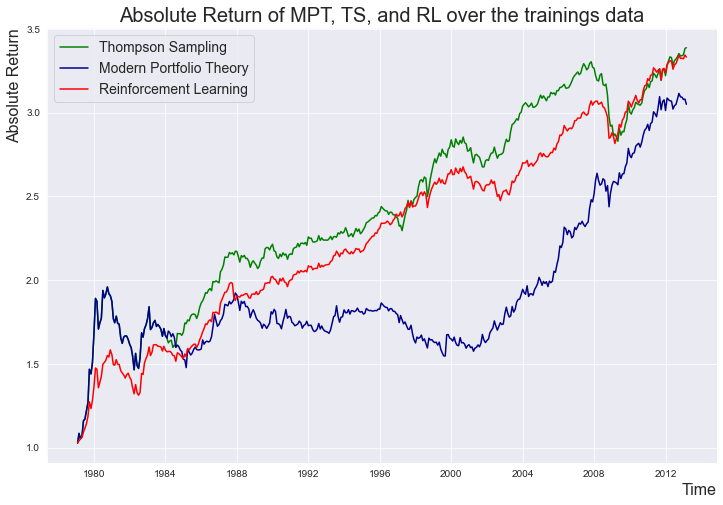

In [15]:
# graphic display of performance over time
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(12, 8))
x = data_all_assets_training.index[120:530]
plt.plot(x, profit_ts_list, label = 'Thompson Sampling', color = 'green')
plt.plot(x, profit_mpt_list, label = 'Modern Portfolio Theory', color = 'darkblue')
#plt.plot(x, profit_rl_list, label = 'Reinforcement Learning', color = 'red', linestyle='dashed')
plt.plot(x, profit_rl_list_corrected, label = 'Reinforcement Learning', color = 'red')
plt.xlabel('Time', loc='right', fontsize=16)
plt.ylabel('Absolute Return', loc='top', fontsize=16)
plt.title('Absolute Return of MPT, TS, and RL over the trainings data', fontsize=20)
plt.legend(fontsize=14)
plt.show()
plt.show()

### Calculate performance measures for training data

In [16]:
num_of_days = (df.index[split_obs] - df.index[0]).days
performance(profit_rl_list_corrected, freq=12, num_of_days=num_of_days)

performance(profit_ts_list, freq=freq, num_of_days=num_of_days)
performance(profit_mpt_list, freq=freq,num_of_days=num_of_days)

average return: 5.18 p.a.%
max. draw down : -12.68%
Risk-return-ratio: 0.21

average return: 5.31 p.a.%
max. draw down : -16.62%
Risk-return-ratio: 0.15

average return: 4.55 p.a.%
max. draw down : -16.62%
Risk-return-ratio: 0.12



### composition of portfolios for training data

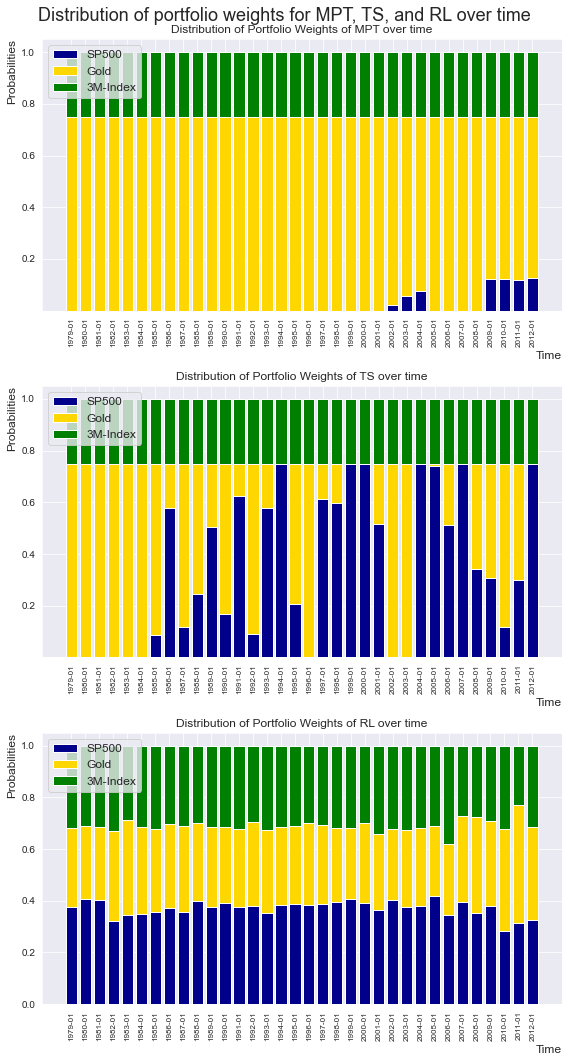

In [24]:
# labels
categories = ['SP500','Gold','3M-Index']
names = ['MPT','TS', 'RL']

portfolio_rl_list = [tensor.tolist() for tensor in portfolio_rl]

portfolios = [portfolio_mpt, portfolio_ts, portfolio_rl_list]

 # set-up graphic
sns.set_style('darkgrid')
fig, ax = plt.subplots(len(portfolios), 1, figsize=(8, 15))

for j, port in enumerate(portfolios):
    # take every 10th portfolio weight and write it into a list 

    container = []
    x_axis = []
    for i in range(math.floor(len(port)/2)):
        container.append(port[i*2])
        x_axis.append(data_all_assets_training.index[start+i*freq*2].strftime('%Y-%m'))

    # x- axis
    n_timepoints = len(container)
    x = np.arange(n_timepoints)

    # define colours
    colors = ['darkblue', 'gold', 'green', 'red']

    # bars starting at zero
    bottom = np.zeros(n_timepoints)

    # stacked bar chart
    for i, category in enumerate(categories):
        heights = [probabilities[i] for probabilities in container]
        ax[j].bar(x, heights, bottom=bottom, label=category, color=colors[i])
        # Update der 'bottom'-Positionen für das nächste Segment
        bottom += heights



        # labelling of axis
        ax[j].set_xlabel('Time', loc='right', fontsize=12)
        ax[j].set_xticks(x)
        ax[j].set_xticklabels(x_axis, fontsize=8, rotation=90)
        ax[j].set_ylabel('Probabilities',loc='top', fontsize=12)
        ax[j].set_title(f'Distribution of Portfolio Weights of {names[j]} over time', fontsize=12)

        # add legend 
        ax[j].legend( loc=2, fontsize=12)

plt.suptitle('Distribution of portfolio weights for MPT, TS, and RL over time', fontsize = 18)
plt.tight_layout()
plt.show()

### Analysis for Test Data
#### Models are trained on entire training data and tested on test data, no synthetic data for RL used

In [58]:
# get data
df = pd.read_csv('../Data/20241010_data.csv', delimiter=";").dropna()
df['Date'] = pd.to_datetime(df['Date'], format='%d.%m.%Y')
# set date column as index
df.set_index('Date', inplace=True)
df.drop('UofM consumer sentiment', axis=1, inplace=True) # drop consumer confidence for now

df.drop('10y treasury Index', axis=1, inplace=True) # drop consumer confidence for now
ten_y_index = [100]
delta = -9.0/100.0
for i in range(len(df['10y'])-1):
    change_in_bp = (df['10y'][i+1] - df['10y'][i])/ df['10y'][i]
    ten_y_index.append(ten_y_index[i] + df['10y'][i]/(12) + change_in_bp * delta)

df['10y treasury Index'] = np.array(ten_y_index)


# split data in training and test set
split = 0.8
split_obs = int(df.shape[0] * split)
df_training = df[0:split_obs]
df_test = df[split_obs::]

data_rl_training = df_training[['SP500', 'Gold', '3M-Index', '10y treasury Index', 'CPI', 'Unemployment', 'non-farm payroll', 'WTI']]
data_rl_test = df_test[['SP500', 'Gold', '3M-Index', '10y treasury Index', 'CPI', 'Unemployment', 'non-farm payroll', 'WTI']]

# instantiate a standard scaler and scale data for RL model
standard_scaler = preprocessing.StandardScaler()
df_training_scaled = standard_scaler.fit_transform(data_rl_training)
df_test_scaled = standard_scaler.transform(data_rl_test)

# select only the assets for the risky portfolio
data_risky_assets_training = df_training[['SP500','Gold']]
data_risky_assets_training = data_risky_assets_training.pct_change().dropna()

data_risky_assets_test = df_test[['SP500','Gold']]
data_risky_assets_test = data_risky_assets_test.pct_change().dropna()

# select data of all assets
data_all_assets_training = df_training[['SP500','Gold','3M-Index']].pct_change()
data_all_assets_test = df_test[['SP500','Gold','3M-Index']].pct_change()





In [59]:

# first 10y of data used to as history for learning and first distribution of prices
start = 120 # in months

# flag if system should retrain
retrain = False
retrain_freq = 120 # in months
freq = 12 # monthly updates for TS
gamma = 1 # parameter of risk aversion

# calculate the mean and the standard deviation of the trainings data
mu = data_risky_assets_training.mean(axis=0).to_numpy() 
sigma = data_risky_assets_training.cov().to_numpy() 

# prior distribtion is given by current data => initial portfolio choice between Thompson Sampling and MPT identical
Thompson_Sampler = AssetThompsonSampler(prior_mu = mu, prior_sigma = sigma, kappa_null = start)


# Reinforecement Learning
df_RL= data_rl_training
model = Reinforcement_Learning(df=df_RL, numb_obs=df_RL.shape[0])

profit_mpt_list = []
profit_ts_list = []
profit_rl_list = []
profit_rl_list_corrected = []

portfolio_mpt = []
portfolio_ts = []
portfolio_rl = []
portfolio_rl_corrected = []

profit_mpt = 1
profit_ts = 1
profit_rl = 1
profit_rl_corrected = 1

efficient_frontier_mpt = calc_efficient_frontier(n_assets=data_risky_assets_test.shape[1], mu=mu, sigma=sigma)

start = freq

for i in range(1, data_all_assets_test.shape[0]):
    # get a sample from each posterior
    post_mu, post_sigma = Thompson_Sampler.drawing_from_posterior_distribution()

       
    # determin the last risk free rate
    r_f = df_test['3M'][i-1]/100
 
    # mpt
    portfolio_choice_mpt = Sharpe_ratio(r_f = r_f, efficient_frontier=efficient_frontier_mpt, gamma=gamma)

    # TS
    efficient_frontier_ts = calc_efficient_frontier(n_assets=data_risky_assets_test.shape[1], mu = post_mu, sigma = post_sigma)
    portfolio_choice_ts = Sharpe_ratio(r_f = r_f, efficient_frontier=efficient_frontier_ts, gamma=gamma)


     # update TS after a complete year of fresh data was collected

    if ((i)%freq==0 ):
        # get a new sample from the real distribution which is unknown
        return_risky_assets =  data_risky_assets_test.iloc[i:i+freq,:].to_numpy().astype(float) 
        
        # update that distributions posterior
        Thompson_Sampler.update_current_distribution(return_risky_assets, freq = freq)

    # performance of assets
    perf_all_assets = data_all_assets_test.iloc[i,:]

    # calulate profit for MPT and Thompson Sampling
    profit_mpt += np.dot(perf_all_assets,portfolio_choice_mpt)
    profit_ts += np.dot(perf_all_assets,portfolio_choice_ts)

    # store profit
    profit_mpt_list.append(profit_mpt)
    profit_ts_list.append(profit_ts)

    # get data for nn model
    obs = pd.DataFrame(df_test_scaled).iloc[i,:].to_numpy().astype(float)
    prob = model(torch.from_numpy(obs).float()) # get probability distribution

    # store the weights of the portfolios
    portfolio_mpt.append(portfolio_choice_mpt)
    portfolio_ts.append(portfolio_choice_ts)
    portfolio_rl.append(prob)
    probability = prob.detach().numpy()
    probability_corrected = np.array([probability[0]+(probability[0]/(probability[0]+probability[1]))*(probability[2]-0.25),probability[1]+(probability[1]/(probability[0]+probability[1]))*(probability[2]-0.25), 0.25])
    portfolio_rl_corrected.append(probability_corrected)

    # calculate profit for RL
    profit_rl += perf_all_assets@prob.detach().numpy()
    profit_rl_corrected += perf_all_assets@probability_corrected
    profit_rl_list.append(profit_rl) 
    profit_rl_list_corrected.append(profit_rl_corrected) 

    if retrain and (i % retrain_freq == 0):
        # calculate the mean and the standard deviation of the data
        mu = data_risky_assets_training.iloc[i-retrain_freq:i,:].mean(axis=0).to_numpy() 
        sigma = data_risky_assets_training.iloc[i-retrain_freq:i,:].cov().to_numpy()


        # prior distribtion is given by current data => initial portfolio choice between Thompson Sampling and MPT identical
        Thompson_Sampler = AssetThompsonSampler(prior_mu = mu, prior_sigma = sigma, kappa_null = split_obs)

        df_RL = data_rl_training[0:i]
        # Reinforecement Learning
        model = Reinforcement_Learning(df=df_RL, numb_obs=i)



Early Stop!


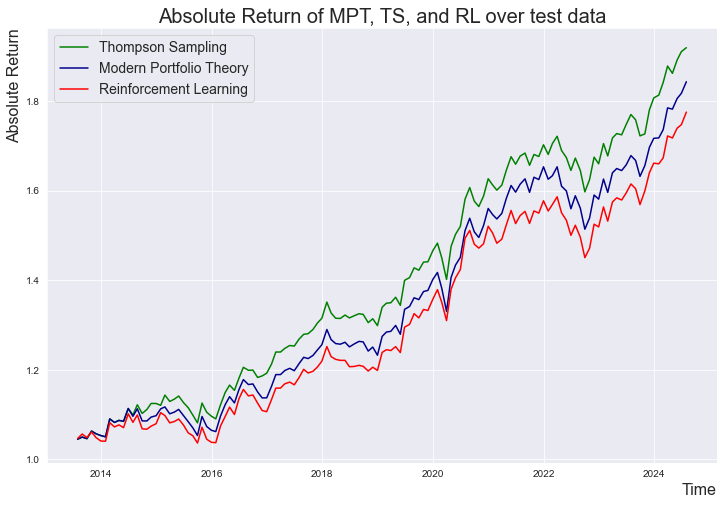

In [62]:
# graphic display of performance over time
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(12, 8))
x = data_all_assets_test.index[1:data_all_assets_test.shape[0]]
plt.plot(x, profit_ts_list, label = 'Thompson Sampling', color = 'green')
plt.plot(x, profit_mpt_list, label = 'Modern Portfolio Theory', color = 'darkblue')
#plt.plot(x, profit_rl_list, label = 'Reinforcement Learning', color = 'red', linestyle='dashed')
plt.plot(x, profit_rl_list_corrected, label = 'Reinforcement Learning', color = 'red')
plt.xlabel('Time', loc='right', fontsize=16)
plt.ylabel('Absolute Return', loc='top', fontsize=16)
plt.title('Absolute Return of MPT, TS, and RL over test data', fontsize=20)
plt.legend(fontsize=14)
plt.show()
plt.show()

### calculate performance measures for test data

In [66]:
num_of_days = (df.index[-1] - df.index[split_obs]).days
performance(profit_rl_list_corrected, freq=freq, num_of_days=num_of_days)
performance(profit_ts_list, freq=freq, num_of_days=num_of_days)
performance(profit_mpt_list, freq=freq,num_of_days=num_of_days)

average return: 6.57 p.a.%
max. draw down : -4.58%
Risk-return-ratio: 0.24

average return: 7.88 p.a.%
max. draw down : -4.89%
Risk-return-ratio: 0.29

average return: 7.19 p.a.%
max. draw down : -5.23%
Risk-return-ratio: 0.26



### composition of portfolios for test data

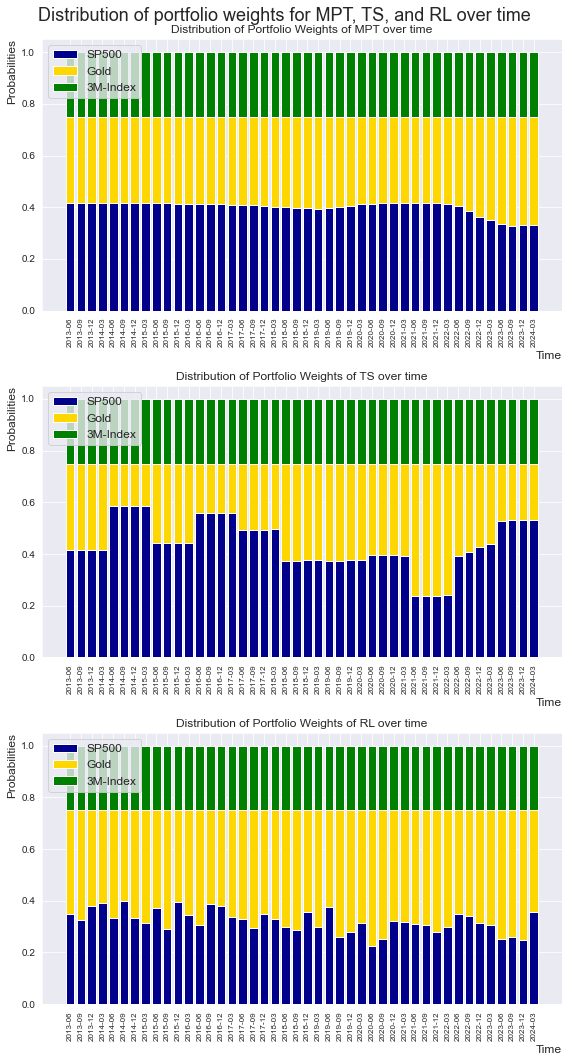

In [75]:
# labels
categories = ['SP500','Gold','3M-Index']
names = ['MPT','TS', 'RL']

portfolio_rl_list = [tensor.tolist() for tensor in portfolio_rl_corrected]

portfolios = [portfolio_mpt, portfolio_ts, portfolio_rl_list]

 # set-up graphic
sns.set_style('darkgrid')
fig, ax = plt.subplots(len(portfolios), 1, figsize=(8, 15))

for j, port in enumerate(portfolios):
    # take every 10th portfolio weight and write it into a list 

    container = []
    x_axis = []
    for i in range(0,math.floor(len(port))-1, 3):
        container.append(port[i])
        x_axis.append(data_all_assets_test.index[i].strftime('%Y-%m'))

    # x- axis
    n_timepoints = len(container)
    x = np.arange(n_timepoints)

    # define colours
    colors = ['darkblue', 'gold', 'green', 'red']

    # bars starting at zero
    bottom = np.zeros(n_timepoints)

    # stacked bar chart
    for i, category in enumerate(categories):
        heights = [probabilities[i] for probabilities in container]
        ax[j].bar(x, heights, bottom=bottom, label=category, color=colors[i])
        # Update der 'bottom'-Positionen für das nächste Segment
        bottom += heights



        # labelling of axis
        ax[j].set_xlabel('Time', loc='right', fontsize=12)
        ax[j].set_xticks(x)
        ax[j].set_xticklabels(x_axis, fontsize=8, rotation=90)
        ax[j].set_ylabel('Probabilities',loc='top', fontsize=12)
        ax[j].set_title(f'Distribution of Portfolio Weights of {names[j]} over time', fontsize=12)

        # add legend 
        ax[j].legend( loc=2, fontsize=12)

plt.suptitle('Distribution of portfolio weights for MPT, TS, and RL over time', fontsize = 18)
plt.tight_layout()
plt.show()

## Add RL+ to analysis on test data

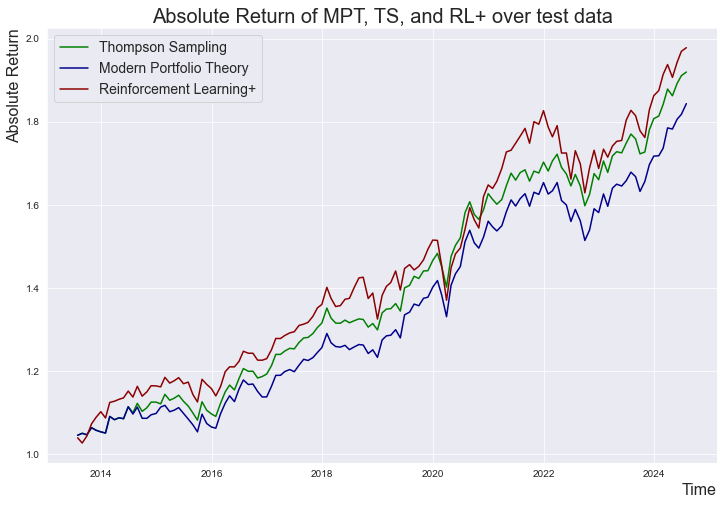

In [105]:
profit_rl_plus = pd.read_csv("output_series_no_index.csv", delimiter=";").dropna()

profit_rl_plus = profit_rl_plus['1.0'].tolist()


# graphic display of performance over time
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(12, 8))
x = data_all_assets_test.index[1:data_all_assets_test.shape[0]]
plt.plot(x, profit_ts_list, label = 'Thompson Sampling', color = 'green')
plt.plot(x, profit_mpt_list, label = 'Modern Portfolio Theory', color = 'darkblue')
plt.plot(x, profit_rl_plus, label = 'Reinforcement Learning+', color = 'darkred')
plt.xlabel('Time', loc='right', fontsize=16)
plt.ylabel('Absolute Return', loc='top', fontsize=16)
plt.title('Absolute Return of MPT, TS, and RL+ over test data', fontsize=20)
plt.legend(fontsize=14)
plt.show()
plt.show()